---------------------------------------------------------------
## VI. CLUSTERING KMEANS SUR BERT SENTENCE TRANSFORMER
--------------------------------------------------------------

On procède ici à une clusterisation Kmeans sur une vectorisation Bert Sentence Transformers du jeu de données préparée précédemment.  

---
### 1. Import des bibliothèques et des données
---

In [104]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc

import umap
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score, calinski_harabasz_score

from sentence_transformers import SentenceTransformer

In [105]:
# Import du jeu de données
df = pd.read_csv('../data/processed/processed_data.csv')

In [106]:
# Afin de simplifier le traitement et de gagner du temps, on peut récupérer l'embedding Sentence entrainés précédemment sur ce dataset ; on peut choisir parmi les deux modèles d'embedding en décommentant la ligne correspondante
src = '../data/processed/document_embeddings_bert_'
model_name = "all-MiniLM-L6-v2"
#model_name = "all-mpnet-base-v2"
model = src + model_name + '.npy'
doc_emb = np.load(model)

---
### 2. Préparation et vectorisation SBERT (facultative si déjà réalisée)
---

In [37]:
# Récupération des longueurs des textes
df['prepr_sign_count']=df['text_prepr'].apply(lambda x : len(str(x)))

(array([30709.,  7795.,  1653.,  2040.,  1354.,   906.,   819.,   915.,
         1028.,  1145.,  1294.,  1482.,  1991.,  2074.,  2011.,  2032.,
         2184.,  1748.,  1264.,   758.]),
 array([   3. ,  151.1,  299.2,  447.3,  595.4,  743.5,  891.6, 1039.7,
        1187.8, 1335.9, 1484. , 1632.1, 1780.2, 1928.3, 2076.4, 2224.5,
        2372.6, 2520.7, 2668.8, 2816.9, 2965. ]),
 <BarContainer object of 20 artists>)

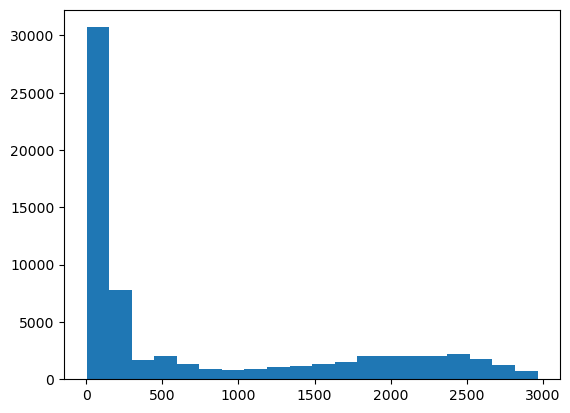

In [39]:
# Affichage de la distribution des longueurs des textes
plt.hist(df['prepr_sign_count'], bins = 20)

In [20]:
# On supprime les colonnes inutiles
df.columns
df = df.drop(['has_similarity', 'similar_with',
       'similarity_group', 'similarity_score', 'prepr_sign_count'], axis = 1)

In [21]:
# Le corpus est alors réuni en "liste extérieure" : chaque article devient un 'document' dans une liste all_docs
all_docs =  [doc for doc in df['text_prepr']]

In [27]:
# On réalise un premier embedding avec le modèle MiniLM
model_MiniLM = SentenceTransformer('all-MiniLM-L6-v2')

# encodage : un vecteur par document
document_embeddings_MiniLM = model_MiniLM.encode(all_docs, show_progress_bar=True)

/Users/thevault/anaconda3/envs/DST_projet_twitter/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Batches:   0%|          | 0/2038 [00:00<?, ?it/s]

In [28]:
# On réalise un second embedding avec le modèle mpnet
model_mpnet = SentenceTransformer('all-mpnet-base-v2')

# encodage : un vecteur par document
document_embeddings_mpnet = model_mpnet.encode(all_docs, show_progress_bar=True)

Batches:   0%|          | 0/2038 [00:00<?, ?it/s]

In [31]:
# Affichage des embeddings du premier modèle
print(document_embeddings_MiniLM)

[[-0.03531276  0.05723779  0.00903547 ...  0.02548492 -0.0213107
   0.02517448]
 [-0.02272386 -0.0010928  -0.00646465 ...  0.00280961  0.02842266
  -0.07352693]
 [ 0.06935943 -0.02982804  0.01241202 ... -0.01132429  0.0649493
  -0.05088305]
 ...
 [-0.08347564 -0.0311508  -0.03408111 ... -0.0370778   0.01656605
   0.05550456]
 [ 0.01938508  0.00529073  0.06846138 ... -0.0152928  -0.07339507
   0.02446632]
 [ 0.06850976  0.01567451  0.03972524 ... -0.10891644 -0.03687358
   0.0269627 ]]


In [32]:
# Affichage des embeddings du second modèle
print(document_embeddings_mpnet)

[[-0.00928337  0.00196794  0.02329338 ...  0.01391749 -0.08473725
  -0.00817604]
 [ 0.00422894  0.02766648 -0.01021543 ...  0.01011313 -0.0175698
  -0.00786792]
 [-0.04324357  0.04418413  0.03253994 ...  0.02945987  0.01592285
  -0.03193568]
 ...
 [-0.0531546   0.07702787  0.0182278  ... -0.05129326 -0.04336146
  -0.01915059]
 [-0.02746027  0.07247823  0.02510124 ...  0.0103333  -0.03237401
   0.01319921]
 [-0.04555516  0.05029323 -0.01367469 ... -0.01323975  0.00702319
   0.01581313]]


In [40]:
# Sauvegarde des embeddings
np.save('../data/processed/document_embeddings_bert_all-MiniLM-L6-v2.npy', document_embeddings_MiniLM)
np.save('../data/processed/document_embeddings_bert_all-mpnet-base-v2.npy', document_embeddings_mpnet)

In [21]:
# Fichier avec les embeddings et classes enregistrées lors d'une séance précédente :
#df=pd.read_excel(r'DATASETS\df_50_3000_BertEmbed_Kmeans_BertTopics.xlsx')

# 2. KMEANS recherche optimum

In [103]:
# On s'assure d'utiliser le bon embedding (cette étape est facultative si le point un n'a été évité et que l'embedding est déjà chargé au début du script)
doc_emb = document_embeddings_MiniLM

In [107]:
start = time.time()

wcss = []     # within cluster sum of square
silhouette_scores = []
for i in [9,20,30,40,45,70,100]:
    km_best = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=1234)
    km_best.fit(doc_emb)
    wcss.append(km_best.inertia_)
    score = silhouette_score(doc_emb, km_best.labels_)
    silhouette_scores.append(score)

stop = time.time()
print("durée d'exécution : ", np.round((stop-start),2), "sec.")

durée d'exécution :  643.22 sec.


In [108]:
print(f"Number of iterations: {km_best.n_iter_}")
wcss

Number of iterations: 117


[47952.54296875,
 44989.0625,
 43672.046875,
 42819.1953125,
 42443.125,
 41104.8515625,
 39978.09375]

Text(0.5, 1.0, 'Inertie vs. Nombre de clusters Kmeans :\n')

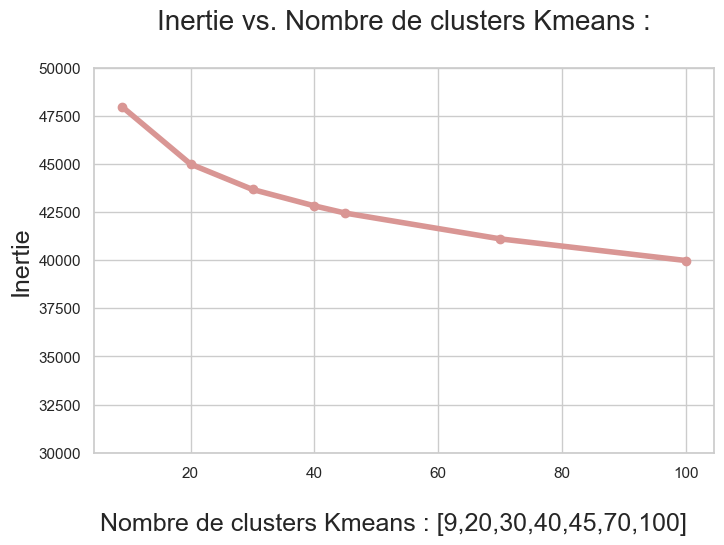

In [109]:
# Perte d'inertie
# -----------------------

sns.set(style="whitegrid", palette="muted")

plt.figure(figsize=(8, 5))
plt.plot([9,20,30,40,45,70,100], wcss, marker='o', linestyle='-', linewidth=4, markersize=6, color='#D99694')

plt.xlabel('\nNombre de clusters Kmeans : [9,20,30,40,45,70,100]   ', fontsize=18)
plt.ylim(30000, 50000)

plt.ylabel('Inertie', fontsize=18)
plt.title('Inertie vs. Nombre de clusters Kmeans :\n', fontsize=20)


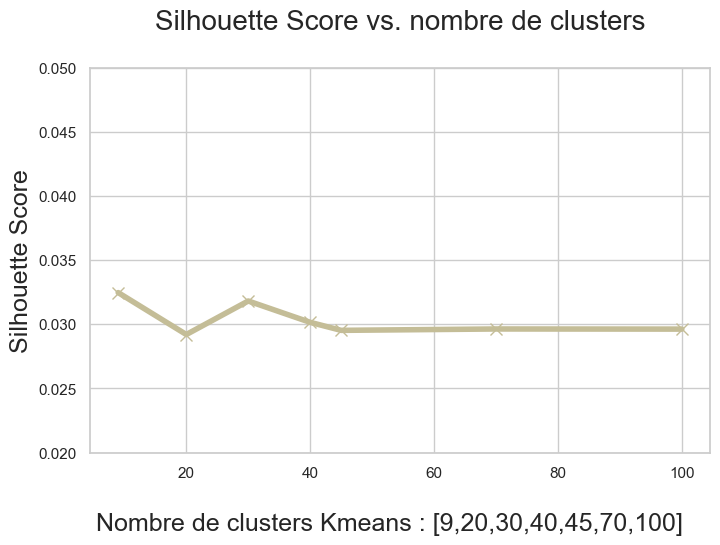

In [110]:
# Silhouette Scores
#----------------------------------------------------------

plt.figure(figsize=(8, 5))
plt.plot([9,20,30,40,45,70,100], silhouette_scores, marker='x', linestyle='-', linewidth=4, markersize=8, color = '#C4BD97')
plt.xlabel('\nNombre de clusters Kmeans : [9,20,30,40,45,70,100]   ', fontsize = 18)
plt.ylabel('Silhouette Score', fontsize = 18)
plt.ylim(0.02, 0.05)
plt.title('Silhouette Score vs. nombre de clusters\n', fontsize=20)
plt.show()

## a. KMEANS : 9

In [111]:
#----------------------------------------
# KMEANS sur base des scores TF IDF
#--------------------------------------

km9 = KMeans(n_clusters=9, init='k-means++', n_init=10, random_state=1234)
km9.fit(doc_emb)

# créer colonne avec labels KMeans
km9.labels_
df['km_labels9'] = km9.labels_

In [112]:
df.head(3)

,id_50_3000,id_origin,text,label,sign_count,text_prepr,has_similarity,similar_with,similarity_group,similarity_score,km_labels9
0,0,55929,Dank is it a tornado n Raleigh car blowincg n shit,0,50,Dank is it a tornado n Raleigh car blowincg n shit,0,NaN,NaN,0.0,6
1,1,51817,@smoak_queen 'I'm going to be in so much trouble.',1,50,I m going to be in so much trouble,0,NaN,NaN,0.0,7
2,2,51709,@CSAresu American Tragedy http://t.co/SDmrzGErYX,0,50,American Tragedy,0,NaN,NaN,0.0,7


km_labels9
0     6627
1     8154
2     6945
3     5976
4     7163
5    10698
6     8440
7     7742
8     3457
Name: count, dtype: int64


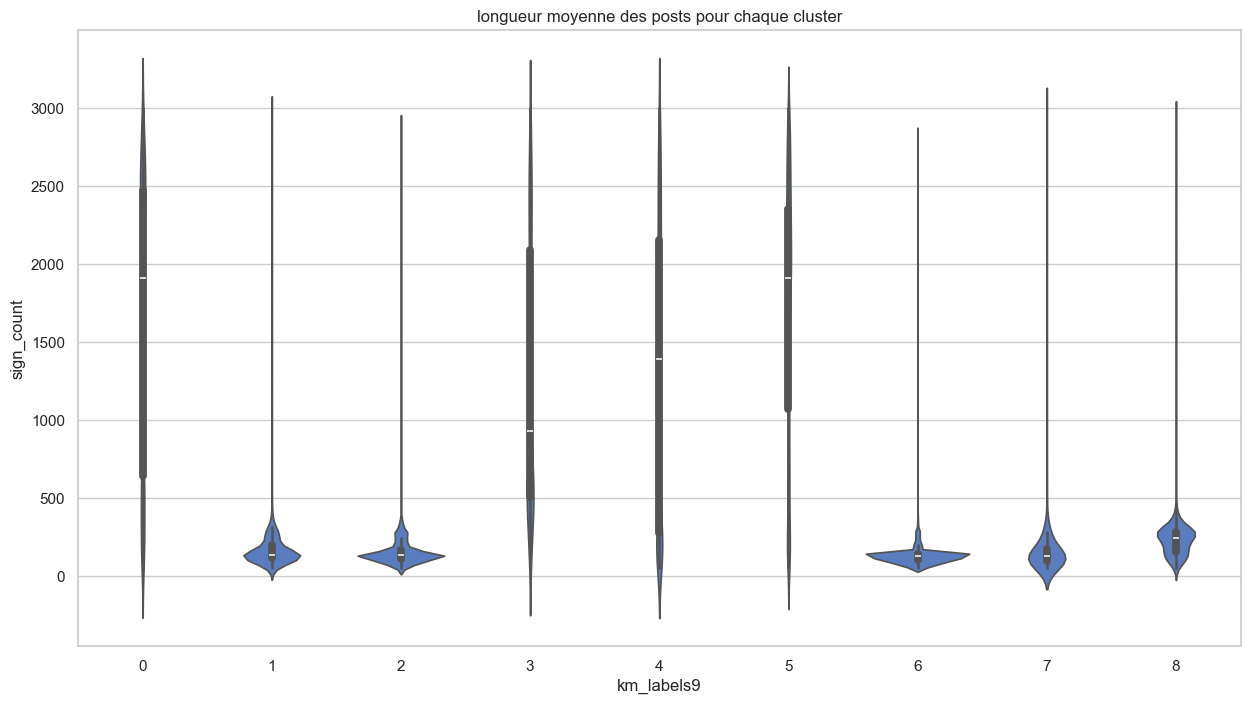

In [113]:
#visualiser les clusters
# 1. LONGUEUR
# ------------------------------------------------------------------------------

#clusters fonction longueurs des posts
print(df['km_labels9'].value_counts().sort_index())

fig, ax = plt.subplots(figsize=[15,8])
sns.violinplot(y="sign_count", x="km_labels9", data=df, ax=ax)
plt.title("longueur moyenne des posts pour chaque cluster")
plt.show()


In [114]:
# Silhouette Scores par cluster
# -----------------------------------

silhouette_vals = silhouette_samples(doc_emb, km9.labels_)

# silhouette scores par cluster
silhouette_per_cluster = []
cluster_i = []
for cluster in range(km9.n_clusters): # n_clusters = nombre clusters
    silhouette_per_cluster.append(np.mean(silhouette_vals[km9.labels_ == cluster]))
    cluster_i.append(cluster)

ZIP=zip(cluster_i, silhouette_per_cluster)
Silh_cluster = pd.DataFrame(ZIP, columns=['Cluster', 'Silhouette Score'])
print("Coefficients solhouette par cluster:")
Silh_cluster

Coefficients solhouette par cluster:


,Cluster,Silhouette Score
0,0,0.018537
1,1,0.055050
2,2,0.052060
3,3,0.027449
4,4,0.013621
5,5,0.066385
6,6,0.028625
7,7,-0.032579
8,8,0.064451


In [115]:
"""
Labellisation à la main, à posteriori
km_labels
0    381 : Inclassable - [courts]
1    235 : Wildfire and climate change - [courts]
2    451 : Floods and consequences on cars, boats, bikes, ... - [courts]
3    529 : Hurricanes and conseuqences on how people stay safe or find safety - [courts]
4    522 : US and int'l public safety and crime - [750 moyenne]
5    403 : US politics - legislation - [2000 moyenne]
6    694 : US politics, Trump and elections - [2000 moyenne]
7    398 : Hurricanes and consequences on food supply - [courts]
8    387 : International news and US international relations - [1000 moyenne]
"""
df.columns

Index(['id_50_3000', 'id_origin', 'text', 'label', 'sign_count', 'text_prepr',
       'has_similarity', 'similar_with', 'similarity_group',
       'similarity_score', 'km_labels9'],
      dtype='object')

In [116]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth',1000)

df[df['km_labels9']==8].head(1)

,id_50_3000,id_origin,text,label,sign_count,text_prepr,has_similarity,similar_with,similarity_group,similarity_score,km_labels9
5,5,48759,@ErinMariefishy everyone is setting flames upon me,1,50,everyone is setting flames upon me,0,NaN,NaN,0.0,8


## b. Kmeans : 15

In [117]:
#----------------------------------------
# KMEANS sur base des vecteurs BERT transf
#--------------------------------------

km15 = KMeans(n_clusters=15, init='k-means++', n_init=10, random_state=1234)
km15.fit(doc_emb)

# créer colonne avec labels KMeans
km15.labels_
df['km_labels15'] = km15.labels_

## c. Kmeans : 20

In [119]:
#----------------------------------------
# KMEANS sur base des vecteurs BERT transf
#--------------------------------------

km20 = KMeans(n_clusters=20, init='k-means++', n_init=10, random_state=1234)
km20.fit(doc_emb)
# créer colonne avec labels KMeans

km20.labels_
df['km_labels20'] = km20.labels_

## d. Kmeans : 25

In [120]:
#----------------------------------------
# KMEANS sur base des vecteurs BERT transf
#--------------------------------------

km25 = KMeans(n_clusters=25, init='k-means++', n_init=10, random_state=1234)
km25.fit(doc_emb)
# créer colonne avec labels KMeans

km25.labels_
df['km_labels25'] = km25.labels_

## e. Kmeans : 30

In [121]:
#----------------------------------------
# KMEANS sur base des vecteurs BERT transf
#--------------------------------------

km30 = KMeans(n_clusters=30, init='k-means++', n_init=10, random_state=1234)
km30.fit(doc_emb)
# créer colonne avec labels KMeans

km30.labels_
df['km_labels30'] = km30.labels_

## f. Kmeans : 45

In [122]:
#----------------------------------------
# KMEANS sur base des vecteurs BERT transf
#--------------------------------------

km45 = KMeans(n_clusters=45, init='k-means++', n_init=10, random_state=1234)
km45.fit(doc_emb)
# créer colonne avec labels KMeans

km45.labels_
df['km_labels45'] = km45.labels_

In [123]:
print(f"Number of iterations: {km45.n_iter_}")

Number of iterations: 91


## g. Kmeans : 100

In [124]:
#----------------------------------------
# KMEANS sur base des vecteurs BERT transf
#--------------------------------------
km100 = KMeans(n_clusters=100, init='k-means++', max_iter = 300, n_init=10, random_state=1234)
km100.fit(doc_emb)
# créer colonne avec labels KMeans

km100.labels_
df['km_labels100'] = km100.labels_

In [125]:
print(f"Number of iterations: {km100.n_iter_}")

Number of iterations: 136


# Kmeans : 200 

In [126]:
#----------------------------------------
# KMEANS sur base des vecteurs BERT transf
#--------------------------------------

km200 = KMeans(n_clusters=200, init='k-means++', max_iter = 300, n_init=10, random_state=1234)
km200.fit(doc_emb)
# créer colonne avec labels KMeans

km200.labels_
df['km_labels200'] = km200.labels_

In [127]:
print(f"Number of iterations: {km200.n_iter_}")
dfread200=df[['text','km_labels200']]
dfread200[dfread200['km_labels200'] == 50]

Number of iterations: 100


,text,km_labels200
4962,69 die in Myanmar floods 250000 affected http://t.co/LxjjGyv86A | https://t.co/U9x3perXCO,50
10567,Chinese rescue team arrives in Myanmar to help flood victims http://t.co/nOSvu0Zx4x Sittway http://t.co/5mJZJNkPfn,50
12260,*books a flight to Burma when country is enduring political unrest and a natural disaster* no wonder it was so cheap ay,50
17772,69 Dead Due to Floods in Myanmar: Naypyidaw Aug 5 (Prensa Latina) The death toll rose today to 69 in Myanmar... http://t.co/JoDs9a32PI,50
20616,Myanmar floods: Childfund https://t.co/pQHQ4JnZTT\n and International Needs https://t.co/FX0W2Sq05F and CARE Aust @CAREemergencies appeals,50
...,...,...
64808,"YANGON (Reuters) - Human rights monitors on Wednesday urged Myanmar to withdraw a ban on protests in its largest city, Yangon, amid fears that free speech is under pressure under the government led by democracy champion Aung San Suu Kyi. Suu Kyi led efforts to end decades of military rule and won a landmark election in the Buddhist-majority country in 2015, but her civilian government shares power with the military and has no control over the army and police. She has also been roundly criticised in the West for failing to rein in the military over its alleged role in atrocities against minority Rohingya Muslims which the United Nations has described as textbook ethnic cleansing. The ban on protests, issued this month by a military-controlled ministry, restricts all applications for processions or assemblies in central Yangon in order to avoid public annoyance and anxiety and disturbance of traffic , according to official documents reviewed by Reuters. The curb came weeks...",50
64815,"NEW DELHI (Reuters) - India has stepped up security along its largely porous eastern border with Bangladesh and is using chilli and stun grenades to block the entry of Rohingya Muslims fleeing from violence in their homeland of Myanmar, officials said on Friday. Border forces in Hindu-majority India, which wants to deport around 40,000 Rohingya already living in the country, citing security risks, have been authorized to use rude and crude methods to stop any infiltration attempts. We don t want to cause any serious injury or arrest them, but we won t tolerate Rohingya on Indian soil, said a senior official with the Border Security Force (BSF) in New Delhi. We re using grenades containing chilli spray to stop hundreds of Rohingyas trying to enter India ... the situation is tense, added the official, who declined to be identified as he was not authorized to speak to media. More than 420,000 Rohingya have fled to Bangladesh since Aug. 25, when a coordinated attack by Rohingy...",50
64854,"KUTUPALONG CAMP, Bangladesh (Reuters) - Aid agencies have to step up operations massively in response to the arrival in Bangladesh of about 400,000 refugees fleeing violence in Myanmar, and the amount of money needed to help them has risen sharply, a senior U.N. official said on Wednesday. The exodus of Muslim Rohingya to Bangladesh began on Aug. 25 after Rohingya militants attacked about 30 police posts and an army camp. The attacks triggered a sweeping military counter-offensive by security forces in Buddhist-majority Myanmar which the U.N. rights agency said was a textbook example of ethnic cleansing . We will all have to ramp up our response massively, from food to shelter, George William Okoth-Obbo, assistant high commissioner for operations at the U.N. refugee agency, told Reuters during a visit to the Kutupalong refugee camp in Bangladesh. The United Nations said on Tuesday 370,000 people had crossed into Bangladesh but Okoth-Obbo estimated the figure was now 400,000. ...",50
64878,"GENEVA (Reuters) - The top U.N. human rights official has said he would not be surprised if a court one day ruled that acts of genocide had been committed against the Rohingya Muslim minority in Myanmar, according to a television interview to be shown on Monday. U.N. High Commissioner for Human Rights Zeid Ra a

In [128]:
#df=pd.to_excel(r'DATASETS\df_50_3000_BertEmbed_Kmeans_BertTopics.xlsx')
#df=df[['text', 'sign_count', 'record', 'id_102661', 'id_50_3000', 'km_labels15', 'km_labels20', 'km_labels25', 'km_labels30','km_labels45','BertEmbeddings', 'BertTopics_26', 'BertTopics_Name', 'BertTopics_48']]

In [129]:
#df.to_excel('df_50_3000_BertEmbed_Kmeans_BertTopic_9_45.xlsx')

km_labels15
0     2836
1     3358
2     2767
3     4388
4     7394
5     4008
6     2665
7     7309
8     5422
9     5462
10    4325
11    2851
12    4415
13    3458
14    4544
Name: count, dtype: int64


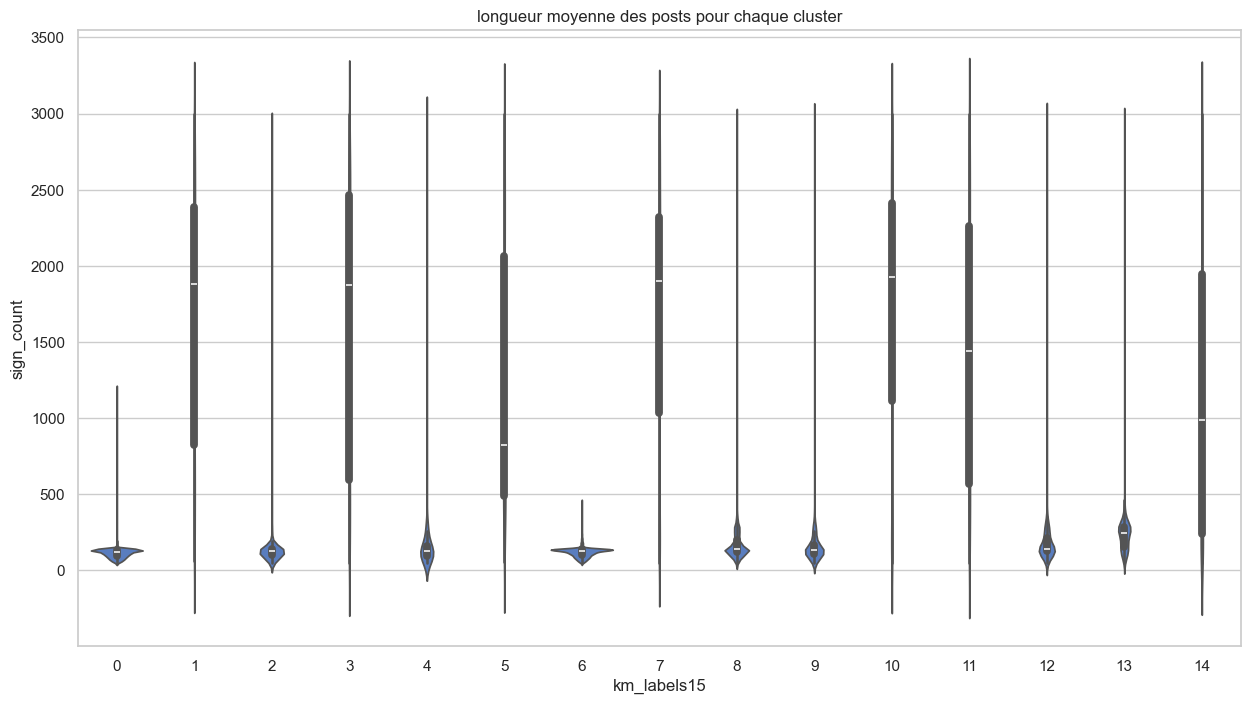

In [130]:
# VISUALISER  les clusters
# 1. LONGUEUR
# ------------------------------------------------------------------------------

#clusters fonction longueurs des posts
print(df['km_labels15'].value_counts().sort_index())


fig, ax = plt.subplots(figsize=[15,8])
sns.violinplot(y="sign_count", x="km_labels15", data=df, ax=ax)
plt.title("longueur moyenne des posts pour chaque cluster")
plt.show()


# 3. Évaluations

## 3.1 Silhouette score par paire

In [131]:

# Silhouette score pour chaque individu
silhouette_vals = silhouette_samples(doc_emb, km15.labels_)

# une liste cluster + 1 liste scores
silhouette_per_cluster = []
cluster_i = []
for cluster in range(km15.n_clusters): # n_clusters = nombre clusters
    # silhouette score moyen (moyenne de tous les individus qui le composent)
    silhouette_per_cluster.append(np.mean(silhouette_vals[km15.labels_ == cluster]))
    cluster_i.append(cluster)

ZIP=zip(cluster_i, silhouette_per_cluster)
Silh_cluster15 = pd.DataFrame(ZIP, columns=['Cluster', 'Silhouette Score'])
print("Coefficients silhouette par cluster:")
Silh_cluster15

Coefficients silhouette par cluster:


,Cluster,Silhouette Score
0,0,0.091961
1,1,0.072382
2,2,0.044051
3,3,0.028739
4,4,-0.040155
5,5,0.030809
6,6,0.058697
7,7,0.031839
8,8,0.046825
9,9,0.034571


In [132]:
"""
km_labels15
0     469 : Divers inclassable
1     331 : Hurricanes and cars, 'ride out', movement
2     313 : US politics & legislation
3     183 : climate events and effects
4     213 : International - middle east / africa
5     262 : US social : equality, spirituality, moral standards
6     239 : US scorched earth : woldfires, climate change
7     262 : Hurricanes, consequences safety, shelters
8     249 : US international relations
9     166 : Tornados, first-person
10    303 : Hurricanes, food supply
11    214 : International news (w/o US)
12    396 : US politics - elections
13    158 : Blizzard - first-person accounts
14    242 : US politics - corruption, investigations, media, FBI, .., 
"""
df.columns

Index(['id_50_3000', 'id_origin', 'text', 'label', 'sign_count', 'text_prepr',
       'has_similarity', 'similar_with', 'similarity_group',
       'similarity_score', 'km_labels9', 'km_labels15', 'km_labels20',
       'km_labels25', 'km_labels30', 'km_labels45', 'km_labels100',
       'km_labels200'],
      dtype='object')

In [79]:
#pd.set_option('display.max_columns', 100)
#pd.set_option('display.max_colwidth',1000)

#df[df['km_labels15']==14].head(2)

## 3.2 : UMAP

In [98]:
reducer = umap.UMAP(n_neighbors=10, min_dist=0.2, n_components=2, random_state=42)

In [99]:
umap_embeddings_2d = reducer.fit_transform(doc_emb)

/Users/thevault/anaconda3/envs/DST_projet_twitter/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [93]:
df['km_labels15'].unique()

array([ 0,  4, 13,  9,  2,  8,  6, 12, 10,  7,  3, 11, 14,  5,  1],
      dtype=int32)

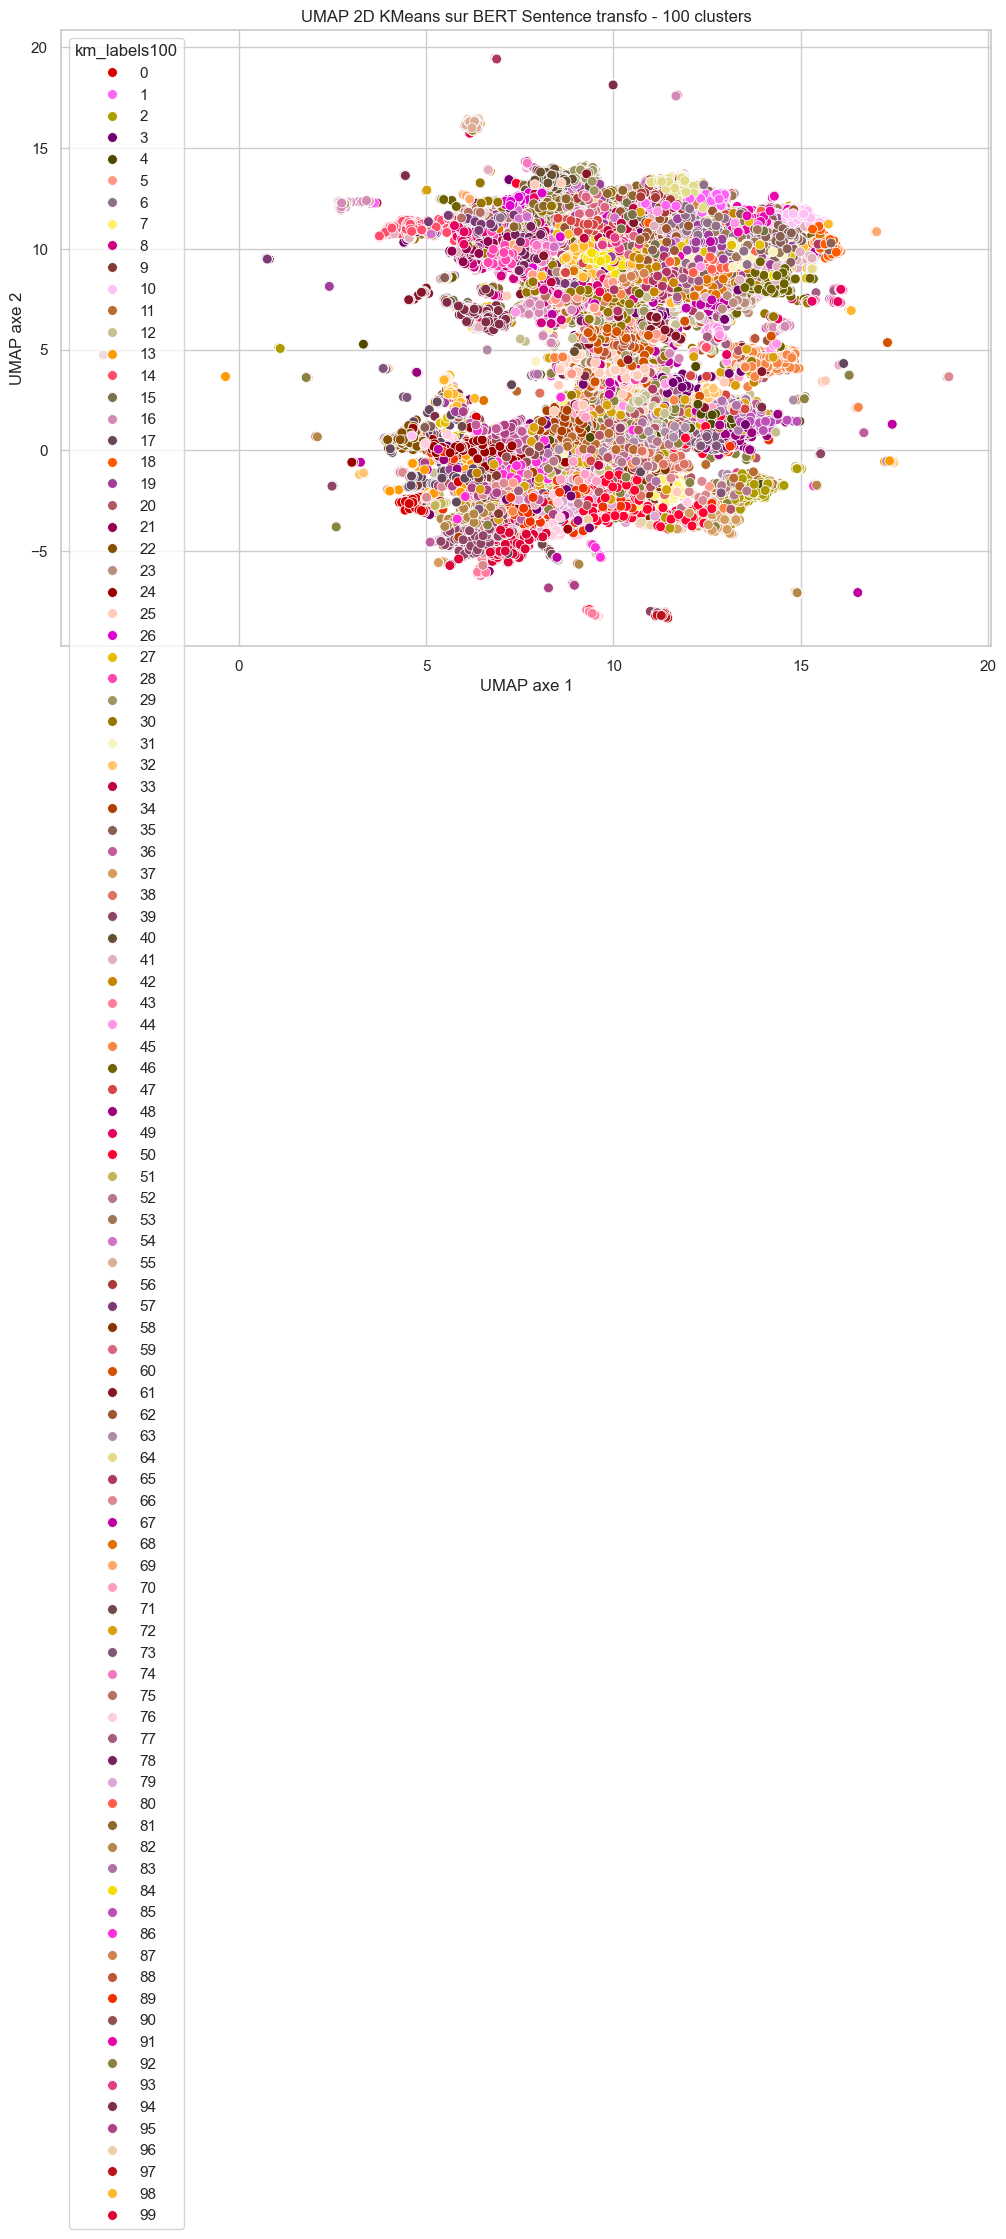

In [95]:
# 100 labels
# -----------------------------------------

palette = sns.color_palette(cc.glasbey_warm, n_colors=100)


plt.figure(figsize=(12,8))
#plt.rcParams['lines.markersize'] = 50 
sns.scatterplot(x=umap_embeddings_2d[:, 0], y=umap_embeddings_2d[:, 1], hue=df['km_labels100'], palette=palette, s=50)


plt.title('UMAP 2D KMeans sur BERT Sentence transfo - 100 clusters')
 
plt.xlabel('UMAP axe 1')
#plt.xlim(-2,16)
plt.ylabel('UMAP axe 2')
#plt.ylim(4,15)
plt.show()

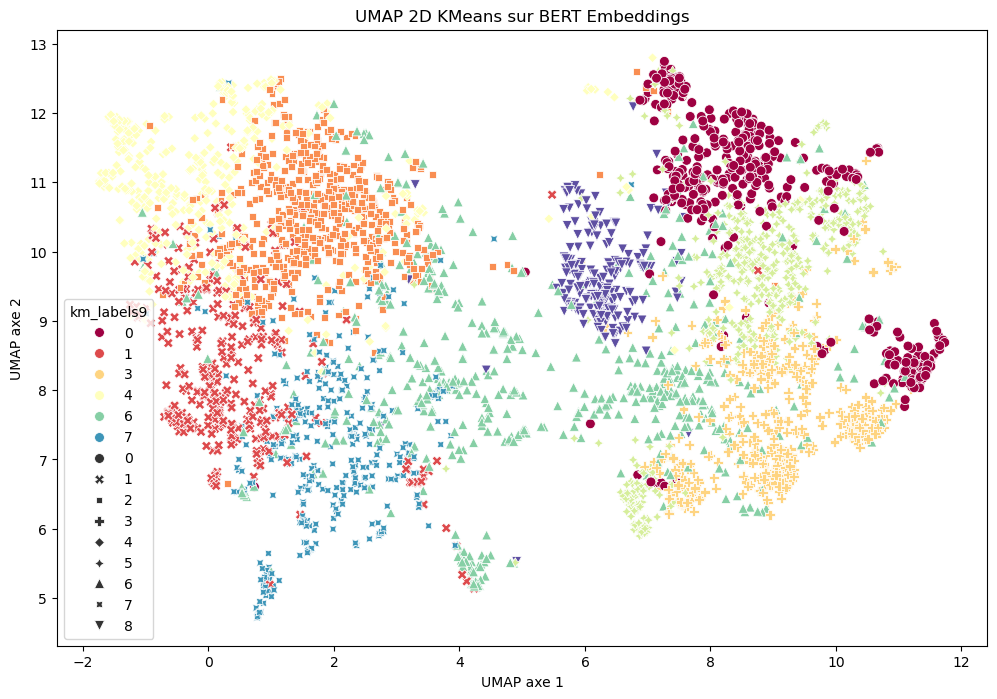

In [41]:
# 9 labels
# -----------------------------------------


plt.figure(figsize=(12,8))

sns.scatterplot(x=umap_embeddings_2d[:, 0], y=umap_embeddings_2d[:, 1], style = df['km_labels9'], hue=df['km_labels9'], palette="Spectral", s=50)


plt.title('UMAP 2D KMeans sur BERT Embeddings')

plt.xlabel('UMAP axe 1')
#plt.xlim(-2,16)
plt.ylabel('UMAP axe 2')
#plt.ylim(4,15)
plt.show()

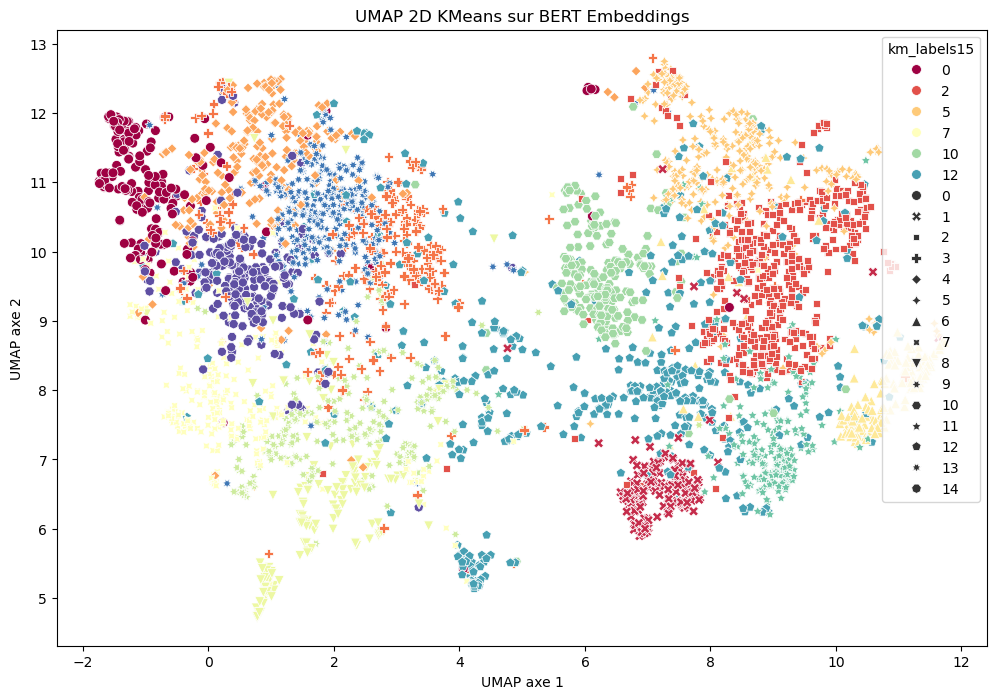

In [40]:
# 15 labels
# -----------------------------------------


plt.figure(figsize=(12,8))

sns.scatterplot(x=umap_embeddings_2d[:, 0], y=umap_embeddings_2d[:, 1], style = df['km_labels15'], hue=df['km_labels15'], palette="Spectral", s=50)


plt.title('UMAP 2D KMeans sur BERT Embeddings')

plt.xlabel('UMAP axe 1')
#plt.xlim(-2,16)
plt.ylabel('UMAP axe 2')
#plt.ylim(4,15)
plt.show()


In [ ]:
"""
km_labels15
0     469 : Divers inclassable
1     331 : Hurricanes and cars, 'ride out', movement
2     313 : US politics & legislation
3     183 : climate events and effects
4     213 : International - middle east / africa
5     262 : US social : equality, spirituality, moral standards
6     239 : US scorched earth : woldfires, climate change
7     262 : Hurricanes, consequences safety, shelters
8     249 : US international relations
9     166 : Tornados, first-person
10    303 : Hurricanes, food supply
11    214 : International news (w/o US)
12    396 : US politics - elections
13    158 : Blizzard - first-person accounts
14    242 : US politics - corruption, investigations, media, FBI, .., 
"""

## 3.3 : inter/intra classe

In [25]:
# 1. RANDOM
# --------------------------------
df['random_class'] = df['km_labels15'].apply(lambda x : np.random.randint(1,16))
df['random_class'].value_counts()


random_class
9     287
15    283
13    281
1     281
10    275
5     274
6     270
2     269
4     265
12    259
7     258
14    256
11    255
3     251
8     236
Name: count, dtype: int64

In [26]:
# évaluation sur random class
# ------------------------------------------



#
dbi = davies_bouldin_score(doc_emb, df['random_class'])
print("Davies-Bouldin Index (DBI):", dbi)

# 
ch_index = calinski_harabasz_score(doc_emb, df['random_class'])
print("Calinski-Harabasz Index:", ch_index)

Davies-Bouldin Index (DBI): 27.131978609513414
Calinski-Harabasz Index: 0.8766204594010745


In [32]:
# 2. BLOCS LONGUEURS
# ----------------------------------------
## le ratio non-zero (densité) diminue avec la longueur des posts

df['bloc'] = pd.cut(df['sign_count'], bins = [0,140,280,1000,3000], labels = ['50 - 140', '140 à 280','280 à 1000', '1000 à 3000'])
df['bloc'].groupby(df.bloc).count()

C:\Users\wf\AppData\Local\Temp\ipykernel_18324\1930162571.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['bloc'].groupby(df.bloc).count()


bloc
50 - 140       24335
140 à 280      10707
280 à 1000      8822
1000 à 3000    20257
Name: bloc, dtype: int64

In [46]:
# évaluation sur blocs longueurs
# ------------------------------------------

# 
dbi = davies_bouldin_score(doc_emb, df['bloc'])
print("Davies-Bouldin Index (DBI):", dbi)

# 
ch_index = calinski_harabasz_score(doc_emb, df['bloc'])
print("Calinski-Harabasz Index:", ch_index)
df.bloc.value_counts()

Davies-Bouldin Index (DBI): 8.930019614450806
Calinski-Harabasz Index: 1464.3145919860988


bloc
50 - 140       24335
1000 à 3000    20257
140 à 280      10707
280 à 1000      8822
Name: count, dtype: int64

In [34]:
df['bloc_simple'] = df['bloc'].apply(lambda x : "0-280" if (x == "50 - 140" or x == "140 à 280") else "281 à 3000")
df['bloc_simple'].value_counts()

bloc_simple
0-280         35042
281 à 3000    29079
Name: count, dtype: int64

In [44]:
# évaluation sur 2 blocs longueurs
# ------------------------------------------


# 
dbi = davies_bouldin_score(doc_emb, df['bloc_simple'])
print("Davies-Bouldin Index (DBI):", dbi)


# 
ch_index = calinski_harabasz_score(doc_emb, df['bloc_simple'])
print("Calinski-Harabasz Index:", ch_index)

Davies-Bouldin Index (DBI): 4.184139729199221
Calinski-Harabasz Index: 3609.005736554935


In [43]:
# 3. 9 CLASSES
# ----------------------------------------
# 
dbi = davies_bouldin_score(doc_emb, df['km_labels9'])
print("Davies-Bouldin Index (DBI):", dbi)


# 
ch_index = calinski_harabasz_score(doc_emb, df['km_labels9'])
print("Calinski-Harabasz Index:", ch_index)

Davies-Bouldin Index (DBI): 4.390384122106307
Calinski-Harabasz Index: 1533.8522900097823


In [47]:
# 4. 15 CLASSES
# ----------------------------------------

# 
dbi = davies_bouldin_score(doc_emb, df['km_labels15'])
print("Davies-Bouldin Index (DBI):", dbi)


# 
ch_index = calinski_harabasz_score(doc_emb, df['km_labels15'])
print("Calinski-Harabasz Index:", ch_index)

Davies-Bouldin Index (DBI): 3.9954720126246284
Calinski-Harabasz Index: 1101.7729291752598


In [48]:
# 4. 20 CLASSES
# ----------------------------------------

# 
dbi = davies_bouldin_score(doc_emb, df['km_labels20'])
print("Davies-Bouldin Index (DBI):", dbi)


# 
ch_index = calinski_harabasz_score(doc_emb, df['km_labels20'])
print("Calinski-Harabasz Index:", ch_index)

Davies-Bouldin Index (DBI): 3.96018654947695
Calinski-Harabasz Index: 909.6455715089073


In [49]:
# 4. 25 CLASSES
# ----------------------------------------

# 
dbi = davies_bouldin_score(doc_emb, df['km_labels25'])
print("Davies-Bouldin Index (DBI):", dbi)


# 
ch_index = calinski_harabasz_score(doc_emb, df['km_labels25'])
print("Calinski-Harabasz Index:", ch_index)

Davies-Bouldin Index (DBI): 3.872943953774101
Calinski-Harabasz Index: 777.1144860266895


In [50]:
# 4. 30 CLASSES
# ----------------------------------------

#
dbi = davies_bouldin_score(doc_emb, df['km_labels30'])
print("Davies-Bouldin Index (DBI):", dbi)



#
ch_index = calinski_harabasz_score(doc_emb, df['km_labels30'])
print("Calinski-Harabasz Index:", ch_index)

Davies-Bouldin Index (DBI): 4.048990563046833
Calinski-Harabasz Index: 679.2072108965248


In [67]:
# 4. 100 CLASSES
# ----------------------------------------


#
dbi = davies_bouldin_score(doc_emb, df['km_labels100'])
print("Davies-Bouldin Index (DBI):", dbi)


# 
ch_index = calinski_harabasz_score(doc_emb, df['km_labels100'])
print("Calinski-Harabasz Index:", ch_index)

Davies-Bouldin Index (DBI): 3.8736759045890325
Calinski-Harabasz Index: 276.6543019365936


In [113]:
# 4. 100 BERT TOPICS
# ----------------------------------------

# 
dbi = davies_bouldin_score(doc_emb, df['BertTopics_100'])
print("Davies-Bouldin Index (DBI):", dbi)

#

# Calculate the Calinski-Harabasz Index
ch_index = calinski_harabasz_score(doc_emb, df['BertTopics_100'])
print("Calinski-Harabasz Index:", ch_index)

Davies-Bouldin Index (DBI): 3.1738019739409222
Calinski-Harabasz Index: 145.0546885198143


In [31]:
df.dtypes

text              object
fake_news          int64
sign_count         int64
text_prepr        object
record             int64
id_102661          int64
id_75300           int64
id_50_3000         int64
km_labels15        int32
random_class       int64
bloc            category
dtype: object

# 4. Estimation du potentiel échantillons 

In [109]:
df['bloc'].value_counts()

bloc
50 - 140       1511
1000 à 3000    1274
140 à 280       644
280 à 1000      571
Name: count, dtype: int64

In [51]:

df['segment_sur_30'] = df['km_labels30'].astype(str) + " - " + df['bloc_simple'].astype(str)
df['segment_sur_30'].value_counts()

segment_sur_30
13 - 0-280         4147
22 - 0-280         3559
24 - 0-280         3026
3 - 281 à 3000     2927
11 - 0-280         2745
4 - 0-280          2686
14 - 0-280         2292
5 - 281 à 3000     2185
15 - 281 à 3000    2144
10 - 281 à 3000    2053
20 - 0-280         2036
28 - 0-280         1931
6 - 281 à 3000     1917
7 - 281 à 3000     1914
29 - 281 à 3000    1896
27 - 0-280         1853
17 - 281 à 3000    1833
19 - 281 à 3000    1743
8 - 281 à 3000     1718
2 - 0-280          1519
16 - 281 à 3000    1497
26 - 281 à 3000    1452
21 - 281 à 3000    1428
9 - 0-280          1328
25 - 0-280         1275
23 - 0-280         1163
12 - 281 à 3000    1156
0 - 0-280          1039
1 - 0-280           744
28 - 281 à 3000     656
20 - 281 à 3000     536
18 - 0-280          503
27 - 281 à 3000     438
15 - 0-280          378
8 - 0-280           357
26 - 0-280          348
29 - 0-280          335
23 - 281 à 3000     316
7 - 0-280           279
18 - 281 à 3000     276
19 - 0-280          254
6

In [119]:
df['segment_sur_9'] = df['km_labels9'].astype(str) + " - " + df['bloc_simple'].astype(str)
df['segment_sur_9'].value_counts()

segment_sur_9
2 - 281 à 3000    585
5 - 0-280         493
6 - 0-280         465
3 - 0-280         451
0 - 0-280         412
4 - 281 à 3000    374
7 - 281 à 3000    338
1 - 281 à 3000    305
8 - 0-280         151
6 - 281 à 3000    109
8 - 281 à 3000     60
2 - 0-280          59
4 - 0-280          54
5 - 281 à 3000     40
1 - 0-280          35
7 - 0-280          35
0 - 281 à 3000     25
3 - 281 à 3000      9
Name: count, dtype: int64

In [55]:
Potential_samples30 = df.groupby(['km_labels30', 'bloc_simple']).count()
Potential_samples30

text  fake_news  sign_count  text_prepr  record  \
km_labels30 bloc_simple                                                    
0           0-280        1039       1039        1039        1039    1039   
            281 à 3000    118        118         118         118     118   
1           0-280         744        744         744         744     744   
            281 à 3000    157        157         157         157     157   
2           0-280        1519       1519        1519        1519    1519   
            281 à 3000    136        136         136         136     136   
3           0-280         217        217         217         217     217   
            281 à 3000   2927       2927        2927        2927    2927   
4           0-280        2686       2686        2686        2686    2686   
            281 à 3000      6          6           6           6       6   
5           0-280         150        150         150         150     150   
            281 à 3000   2185       2185        2185        2185    2185   
6           0-280         234        234         234         234     234   
            281 à 3000   1917       1917        1917        1917    1917   
7           0-280         279        279         279         279     279   
            281 à 3000   1914       1914        1914        1914    1914   
8           0-280         357        357         357         357     357   
            281 à 3000   1718       1718        1718        1718    1718   
9           0-280        1328       1328        1328        1328    1328   
            281 à 3000      9          9           9           9       9   
10          0-280         124        124         124         124     124   
            281 à 3000   2053       2053        2053        2053    2053   
11          0-280        2745       2745        2745        2745    2745   
            281 à 3000     89         89          89          89      89   
12          0-280          99         99          99          99      99   
            281 à 3000   1156       1156        1156        1156    1156   
13          0-280        4147       4147        4147        4147    4147   
            281 à 3000    157        157         157         157     157   
14          0-280        2292       2292        2292        2292    2292   
            281 à 3000     15         15          15          15      15   
15          0-280         378        378         378         378     378   
            281 à 3000   2144       2144        2144        2144    2144   
16          0-280          88         88          88          88      88   
            281 à 3000   1497       1497        1497        1497    1497   
17          0-280         232        232         232         232     232   
            281 à 3000   1833       1833        1833        1833    1833   
18          0-280         503        503         503         503     503   
            281 à 3000    276        276         276         276     276   
19          0-280         254        254         254         254     254   
            281 à 3000   1743       1743        1743        1743    1743   
20          0-280        2036       2036        2036        2036    2036   
            281 à 3000    536        536         536         536     536   
21          0-280         101        101         101         101     101   
            281 à 3000   1428       1428        1428        1428    1428   
22          0-280        3559       3559        3559        3559    3559   
            281 à 3000    151        151         151         151     151   
23          0-280        1163       1163        1163        1163    1163   
            281 à 3000    316        316         316         316     316   
24          0-280        3026       3026        3026        3026    3026   
            281 à 3000    153        153         153         153     153   
25          0-280        1275       1275        1275        1275    1275 

In [57]:
Potential_samples30.columns
Potential_samples30 = Potential_samples30[['segment_sur_30']]
#Potential_samples30 = Potential_samples30
Potential_samples30 = Potential_samples30.astype(int)
print(Potential_samples30['segment_sur_30'].sum())
Potential_samples30

64121


segment_sur_30
km_labels30 bloc_simple                
0           0-280                  1039
            281 à 3000              118
1           0-280                   744
            281 à 3000              157
2           0-280                  1519
            281 à 3000              136
3           0-280                   217
            281 à 3000             2927
4           0-280                  2686
            281 à 3000                6
5           0-280                   150
            281 à 3000             2185
6           0-280                   234
            281 à 3000             1917
7           0-280                   279
            281 à 3000             1914
8           0-280                   357
            281 à 3000             1718
9           0-280                  1328
            281 à 3000                9
10          0-280                   124
            281 à 3000             2053
11          0-280                  2745
            281 à 3000               89
12          0-280                    99
            281 à 3000             1156
13          0-280                  4147
            281 à 3000              157
14          0-280                  2292
            281 à 3000               15
15          0-280                   378
            281 à 3000             2144
16          0-280                    88
            281 à 3000             1497
17          0-280                   232
            281 à 3000             1833
18          0-280                   503
            281 à 3000              276
19          0-280                   254
            281 à 3000             1743
20          0-280                  2036
            281 à 3000              536
21          0-280                   101
            281 à 3000             1428
22          0-280                  3559
            281 à 3000              151
23          0-280                  1163
            281 à 3000              316
24          0-280                  3026
            281 à 3000              153
25          0-280                  1275
            281 à 3000                3
26          0-280                   348
            281 à 3000             1452
27          0-280                  1853
            281 à 3000              438
28          0-280                  1931
            281 à 3000              656
29          0-280                   335
            281 à 3000             1896

In [129]:
Potential_samples9 = df.groupby(['km_labels9', 'bloc_simple']).count()

Potential_samples9

4000


text  fake_news  sign_count  text_prepr  record  \
km_labels9 bloc_simple                                                    
0          0-280         412        412         412         412     412   
           281 à 3000     25         25          25          25      25   
1          0-280          35         35          35          35      35   
           281 à 3000    305        305         305         305     305   
2          0-280          59         59          59          59      59   
           281 à 3000    585        585         585         585     585   
3          0-280         451        451         451         451     451   
           281 à 3000      9          9           9           9       9   
4          0-280          54         54          54          54      54   
           281 à 3000    374        374         374         374     374   
5          0-280         493        493         493         493     493   
           281 à 3000     40         40          40          40      40   
6          0-280         465        465         465         465     465   
           281 à 3000    109        109         109         109     109   
7          0-280          35         35          35          35      35   
           281 à 3000    338        338         338         338     338   
8          0-280         151        151         151         151     151   
           281 à 3000     60         60          60          60      60   

                        id_102661  id_75300  id_50_3000  km_labels15  bloc  \
km_labels9 bloc_simple                                                       
0          0-280              412       412         412          412   412   
           281 à 3000          25        25          25           25    25   
1          0-280               35        35          35           35    35   
           281 à 3000         305       305         305          305   305   
2          0-280               59        59          59           59    59   
           281 à 3000         585       585         585          585   585   
3          0-280              451       451         451          451   451   
           281 à 3000           9         9           9            9     9   
4          0-280               54        54          54           54    54   
           281 à 3000         374       374         374          374   374   
5          0-280              493       493         493          493   493   
           281 à 3000          40        40          40           40    40   
6          0-280              465       465         465          465   465   
           281 à 3000         109       109         109          109   109   
7          0-280               35        35          35           35    35   
           281 à 3000         338       338         338          338   338   
8          0-280              151       151         151          151   151   
           281 à 3000          60        60          60           60    60   

                        segment_sur_15  segment_sur_9  
km_labels9 bloc_simple                                 
0          0-280                   412            412  
           281 à 3000               25             25  
1          0-280                    35             35  
           281 à 3000              305            305  
2          0-280                    59             59  
           281 à 3000              585            585  
3          0-280                   451            451  
           281 à 3000                9              9  
4          0-280                    54             54  
           281 à 3000              374            374  
5          0-280                   493            493  
           281 à 3000               40             40  
6          0-280                   465            465  
           281 à 3000              109            109  
7          0-280                    35             35  
          

In [133]:
Potential_samples9.columns
Potential_samples9 = Potential_samples9[['segment_sur_9']]
#Potential_samples9 = Potential_samples9*(64000/4000)
Potential_samples9 = Potential_samples9.astype(int)
print(Potential_samples9['segment_sur_9'].sum())
Potential_samples9

64000


segment_sur_9
km_labels9 bloc_simple               
0          0-280                 6592
           281 à 3000             400
1          0-280                  560
           281 à 3000            4880
2          0-280                  944
           281 à 3000            9360
3          0-280                 7216
           281 à 3000             144
4          0-280                  864
           281 à 3000            5984
5          0-280                 7888
           281 à 3000             640
6          0-280                 7440
           281 à 3000            1744
7          0-280                  560
           281 à 3000            5408
8          0-280                 2416
           281 à 3000             960